# Содержание
1. [Подготовка данных](#section-1)

   1.1 [Загружаем данные и изучим их](#section-11)
   
   1.2 [Обработаем аномалии в столбцах](#section-12)
   
   1.3 [Удалим неинформативные признаки](#section-13)
   
   1.4 [Заполним пропущенные значения](#section-14) 
   
   
2. [Обучение моделей](#section-2)

   2.1 [Подготовим выборки для обучения моделей](#section-21)
   
   2.2 [Обучим разные модели](#section-22)
   
   2.3 [Проанализируем время обучения, время предсказания и качество моделей](#section-23)
   
   
3. [Анализ моделей](#section-3)

   3.1 [Проверим качество лучшей модели на тестовой выборке](#section-31)
   
   3.2 [Визуализируем важность признаков в модели CatBoost](#section-32)
   
   
4. [Чек-лист проверки](#section-4)


# **<p style="text-align: center;">Определение стоимости автомобилей.</p>**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В проекте представлены технические характеристики, комплектации и цены автомобилей. Задача: построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<img src="https://bu63.ru/images/articles/servis/service.jpeg" alt="Avto" width="30%" height="30%">

**<p style="text-align: center;">Описание данных:</p>**

**Признаки:**

DateCrawled — дата скачивания анкеты из базы

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность (л. с.)

Model — модель автомобиля

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

Repaired — была машина в ремонте или нет

DateCreated — дата создания анкеты

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя)

LastSeen — дата последней активности пользователя

**Целевой признак:**

Price — цена (евро)

## Подготовка данных

In [1]:
pip install --upgrade lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install sweetviz

Note: you may need to restart the kernel to use updated packages.


In [3]:
import re
import time

import numpy as np
import pandas as pd
import seaborn as sns
import sweetviz as sv
import matplotlib.pyplot as plt
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from IPython.display import IFrame

import lightgbm as lgb
from catboost import CatBoostRegressor

### Загружаем данные и изучим их.

In [4]:
avto_df = pd.read_csv('/datasets/autos.csv')

In [5]:
avto_df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
avto_df.columns = avto_df.columns.map(lambda x: re.sub('([a-z0-9])([A-Z])', r'\1_\2', x)).str.lower()

print(avto_df.columns)

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')


***Преобразовали camelCase в snake_case для названий столбцов.***

In [7]:
avto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

Видно, что некоторые столбцы имеют пропущенные значения. Например, "vehicle_type", "gearbox", "model", "fuel_type" и "repaired". Для каждого столбца нужно решить, как заполнять пропуски. 
Столбцы "date_crawled", "date_created" и "last_seen" представлены как строки, но это даты. Преобразуем их в формат даты для дальнейшей работы.

In [8]:
avto_df['date_created'] = pd.to_datetime(avto_df['date_created'])
avto_df['date_crawled'] = pd.to_datetime(avto_df['date_crawled'])
avto_df['last_seen'] = pd.to_datetime(avto_df['last_seen'])

In [9]:
avto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

In [10]:
duplicates = avto_df.duplicated()

print("Количество явных дубликатов:", duplicates.sum())

Количество явных дубликатов: 4


In [11]:
avto_df = avto_df.drop_duplicates()

print("Количество явных дубликатов после удаления:", avto_df.duplicated().sum())

Количество явных дубликатов после удаления: 0


### Обработаем аномалии в столбцах. 

In [12]:
avto_df.describe(include='all', datetime_is_numeric=True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
date_crawled,354365,NaN,NaN,NaN,2016-03-21 12:58:09.520460544,2016-03-05 14:06:22,2016-03-13 11:52:33,2016-03-21 17:50:55,2016-03-29 14:37:20,2016-04-07 14:36:58,NaN
price,354365.0,NaN,NaN,NaN,4416.67983,0.0,1050.0,2700.0,6400.0,20000.0,4514.176349
vehicle_type,316875,8,sedan,91457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
registration_year,354365.0,NaN,NaN,NaN,2004.234481,1000.0,1999.0,2003.0,2008.0,9999.0,90.228466
gearbox,334532,2,manual,268249,NaN,NaN,NaN,NaN,NaN,NaN,NaN
power,354365.0,NaN,NaN,NaN,110.093816,0.0,69.0,105.0,143.0,20000.0,189.85133
model,334660,250,golf,29232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kilometer,354365.0,NaN,NaN,NaN,128211.363989,5000.0,125000.0,150000.0,150000.0,150000.0,37905.083858
registration_month,354365.0,NaN,NaN,NaN,5.71465,0.0,3.0,6.0,9.0,12.0,3.726432
fuel_type,321470,7,petrol,216349,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Рассмотрим аномалии:**

***price:***

- Минимальное значение нулевое. Это ошибка, так как цена автомобиля не может быть нулевой. 

***registration_year:***

- Минимальное значение 1000, а максимальное 9999. Такие значения явно аномальные. 

***power:***

- Максимальное значение 20000. Такое значение мощности кажется нереалистичным для большинства автомобилей. 

***registration_month:***

- Значение месяца регистрации 0 тоже является аномальным.

Рассмотрим эти данные и решим, что с ними делать.



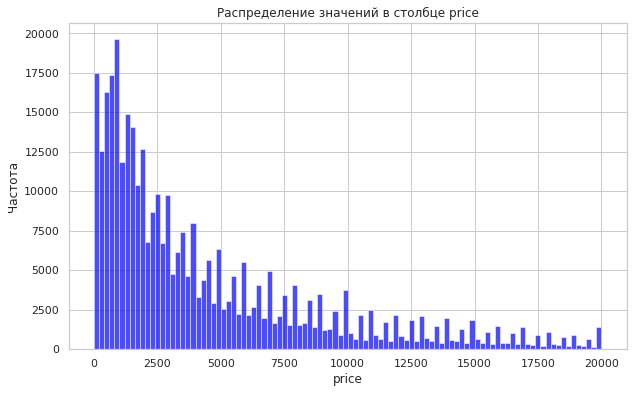

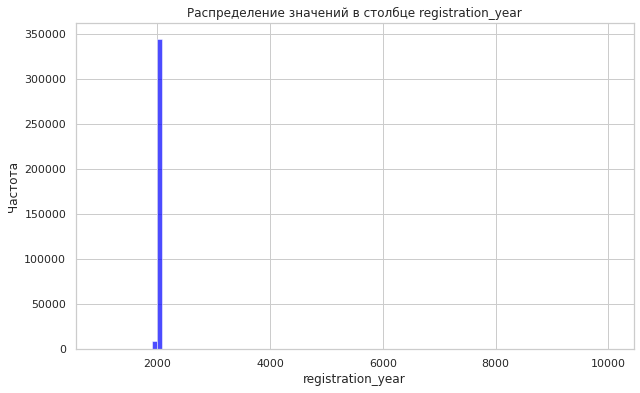

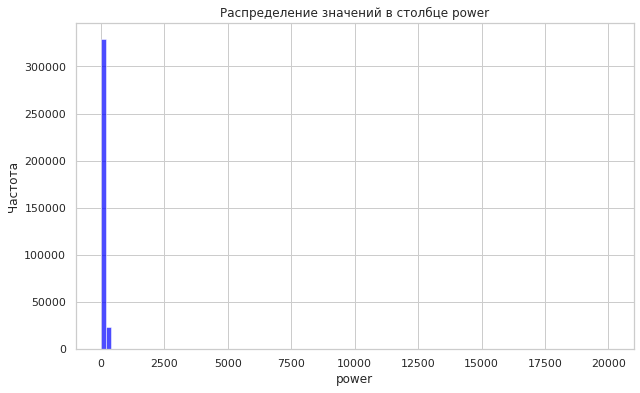

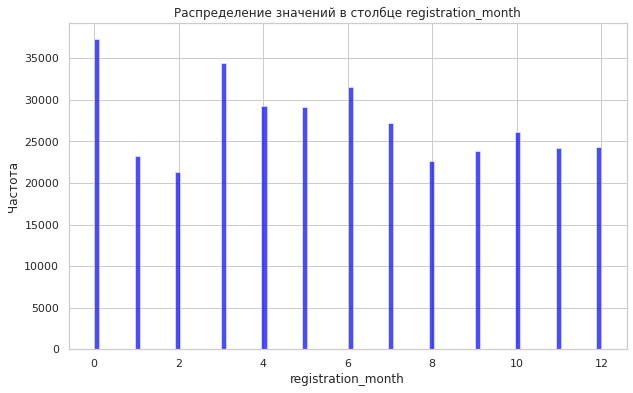

In [13]:
sns.set(style="whitegrid")

columns_with_anomalies = ['price', 'registration_year', 'power', 'registration_month']

for column in columns_with_anomalies:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=avto_df, x=column, bins=100, color='blue', alpha=0.7)
    plt.title(f'Распределение значений в столбце {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()

In [14]:
report = sv.analyze(avto_df)

report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [15]:
print(os.getcwd())

/home/jovyan/work


In [16]:
IFrame(src='./SWEETVIZ_REPORT.html', width=800, height=600)

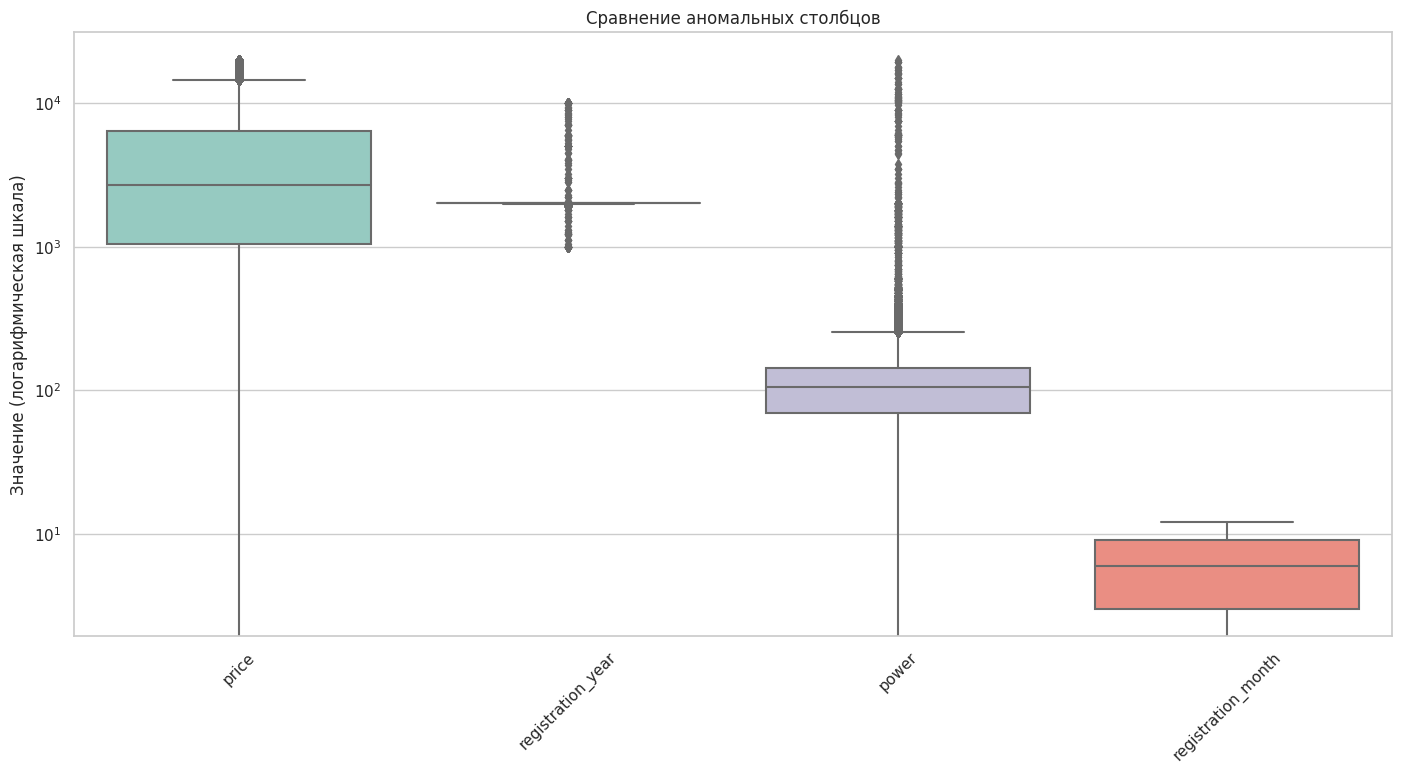

In [17]:
sns.set(style="whitegrid")

plt.figure(figsize=(17, 8))
sns.boxplot(data=avto_df[columns_with_anomalies], palette='Set3')
plt.title('Сравнение аномальных столбцов')
plt.ylabel('Значение (логарифмическая шкала)')
plt.xticks(rotation=45)
plt.yscale('log')
plt.show()

***Посмотрим уникальные значения в столбцах 'power' и 'registration_year' , какие значения являются реалистичными, а какие являются аномальными. Например, в столбце "registration_year" реалистичные значения будут находиться в каком-то разумном временном диапазоне, а в столбце "power" реалистичные значения мощности будут зависеть от типа автомобиля.***

In [18]:
# Уникальные значения в столбце 'registration_year'
sorted_registration_years = np.sort(avto_df['registration_year'].unique())
print("Отсортированные уникальные значения в столбце 'registration_year':")
print(sorted_registration_years)

Отсортированные уникальные значения в столбце 'registration_year':
[1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2066 2200 2222 2290 2500 2800 2900 3000 3200 3500 3700 3800 4000
 4100 4500 4800 5000 5300 5555 5600 5900 5911 6000 6500 7000 7100 7500
 7800 8000 8200 8455 8500 8888 9000 9229 9450 9996 9999]


In [19]:
filtered_data = avto_df[(avto_df['registration_year'] >= 2000) & (avto_df['registration_year'] <= 2019)]
count_in_range = filtered_data.shape[0]
print("Количество данных в диапазоне 2000-2019 год:", count_in_range)

Количество данных в диапазоне 2000-2019 год: 252008


Годы выпуска автомобилей в диапазоне от 2000 до 2019 года выглядят вполне реалистичными и актуальными. Этот период соответствует среднему сроку эксплуатации автомобиля.

Следовательно, будем считать годы выпуска за пределами диапазона 2000-2019 года аномальными. Они могут быть исключены из анализа, чтобы обеспечить более точное представление о данных и избежать искажений при дальнейшем анализе и моделировании

In [20]:
avto_df = avto_df[(avto_df['registration_year'] >= 2000) & (avto_df['registration_year'] <= 2019)]
print(avto_df['registration_year'].describe())

count    252008.00000
mean       2006.40559
std           4.91290
min        2000.00000
25%        2002.00000
50%        2006.00000
75%        2009.00000
max        2019.00000
Name: registration_year, dtype: float64


In [21]:
avto_df['registration_crawled_diff'] = avto_df['date_crawled'] - pd.to_datetime(avto_df['registration_year'], format='%Y')
anomalies = avto_df[avto_df['registration_crawled_diff'] < pd.Timedelta(days=0)]
print(anomalies[['registration_year', 'date_crawled', 'registration_crawled_diff']])

        registration_year        date_crawled registration_crawled_diff
22                   2018 2016-03-23 14:52:51       -649 days +14:52:51
26                   2017 2016-03-10 19:38:18       -297 days +19:38:18
48                   2017 2016-03-25 14:40:12       -282 days +14:40:12
51                   2017 2016-03-07 18:57:08       -300 days +18:57:08
57                   2018 2016-03-10 20:53:19       -662 days +20:53:19
...                   ...                 ...                       ...
354112               2017 2016-03-11 15:49:51       -296 days +15:49:51
354140               2017 2016-03-29 16:47:29       -278 days +16:47:29
354203               2018 2016-03-17 00:56:26       -655 days +00:56:26
354253               2018 2016-03-25 09:37:59       -647 days +09:37:59
354289               2017 2016-03-05 14:55:29       -302 days +14:55:29

[14425 rows x 3 columns]


Просмотр даты выгрузки анкет является полезным для обнаружения аномалий и выбросов в столбце registration_year. В данных о продаже автомобилей дата регистрации не может быть позже даты выгрузки, поэтому любая дата регистрации, превышающая дату выгрузки, может считаться аномалией.

Я проверила этот аспект, вычислив разницу между датой регистрации и датой выгрузки.

В столбце registration_crawled_diff указана разница между годом регистрации и датой выгрузки анкеты. Это значение отрицательное, потому что год регистрации указан как будто бы до даты выгрузки.

Например, первая строка указывает, что автомобиль был зарегистрирован в 2018 году, но анкета была выгружена 23 марта 2016 года, что приводит к отрицательной разнице в -649 дней (и 14 часов 52 минуты 51 секунду). Аналогично, остальные строки также указывают на аномально низкие годы регистрации относительно даты выгрузки.

Эти аномалии могут указывать на ошибки в данных и требуют дополнительного анализа и обработки, такой как удаление или коррекция аномальных записей

In [22]:
# Уникальные значения в столбце 'power'
sorted_power_values = np.sort(avto_df['power'].unique())
print("\nОтсортированные уникальные значения в столбце 'power':")
print(sorted_power_values)


Отсортированные уникальные значения в столбце 'power':
[    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    23    24
    25    26    27    29    30    31    33    34    35    36    37    38
    39    40    41    42    43    44    45    46    47    48    49    50
    51    52    53    54    55    56    57    58    59    60    61    62
    63    64    65    66    67    68    69    70    71    72    73    74
    75    76    77    78    79    80    81    82    83    84    85    86
    87    88    89    90    91    92    93    94    95    96    97    98
    99   100   101   102   103   104   105   106   107   108   109   110
   111   112   113   114   115   116   117   118   119   120   121   122
   123   124   125   126   127   128   129   130   131   132   133   134
   135   136   137   138   139   140   141   142   143   144   145   146
   147   148   149   150   151   152   153   154   155   156   157  

In [23]:
avto_df = avto_df[(avto_df['power'] >= 10) & (avto_df['power'] <= 2000)]
print(avto_df['power'].describe())

count    226015.000000
mean        126.396620
std          63.433067
min          10.000000
25%          86.000000
50%         116.000000
75%         150.000000
max        2000.000000
Name: power, dtype: float64


В столбце 'power' также присутствуют аномальные значения, которые выходят за разумные пределы мощности автомобилей. Эти значения могут быть результатом ошибок ввода или некорректных данных.Применим аналогичный подход, как мы делали для столбца 'registration_year'. Оставим только те строки, где мощность находится в разумном диапазоне, например, от 10 до 2000 лошадиных сил.

- Машины без двигателя: Это могут быть машины, которые были разобраны на запчасти, и двигатель был извлечен. Это также может быть случай машин, созданных без двигателя, например, электрических автомобилей, которые используют электрические моторы вместо внутреннего сгорания. В этом случае мощность будет нулевой.

- Ошибка в данных: Нулевая мощность может также быть следствием ошибки в данных. Это может произойти, если данные были введены неправильно или если информация о мощности отсутствует или некорректна.
    
- Новые машины: В некоторых странах и штатах требуется указывать мощность автомобиля при продаже. Новые машины могут иметь нулевую мощность до того момента, пока они не будут зарегистрированы и мощность не будет оценена.

- Специализированные транспортные средства: Некоторые специализированные транспортные средства, такие как тракторы или специальная строительная техника, могут иметь нулевую мощность, так как они не оборудованы стандартными двигателями для передвижения по дорогам.

In [24]:
zero_price_count = avto_df[avto_df['price'] == 0].shape[0]
print("Количество строк с нулевой ценой:", zero_price_count)

Количество строк с нулевой ценой: 3497


In [25]:
rows_with_zero_price = avto_df[avto_df['price'] == 0]
grouped = rows_with_zero_price.groupby(['brand', 'model', 'gearbox', 'fuel_type','power','kilometer'])['price'].count()
sorted_grouped = grouped.sort_values(ascending=False)
print(sorted_grouped.head(10))

brand       model   gearbox  fuel_type  power  kilometer
volkswagen  golf    manual   petrol     75     150000       32
ford        focus   manual   petrol     101    150000       21
kia         rio     manual   gasoline   90     90000        18
opel        vivaro  manual   gasoline   101    80000        16
volkswagen  polo    manual   petrol     60     150000       15
            passat  manual   gasoline   140    150000       14
bmw         3er     manual   gasoline   150    150000       11
opel        astra   manual   gasoline   150    150000       10
audi        a6      auto     gasoline   180    150000       10
fiat        punto   manual   petrol     60     150000       10
Name: price, dtype: int64


Мы получили группированные данные, показывающие характеристики автомобилей, у которых нулевая цена. Эти данные позволяют проанализировать, есть ли какие-либо закономерности. Например:

- Бренд и Модель: Бренды "Volkswagen" и "Ford" имеют больше всего автомобилей с нулевой ценой, с моделями "Golf" и "Focus" соответственно.

- Тип Коробки Передач: Большинство автомобилей с нулевой ценой имеют ручную коробку передач.

- Мощность: Мощность двигателя варьируется, но преимущественно это небольшие значения.

- Пробег: Большинство автомобилей с нулевой ценой имеют высокий пробег (150,000 км).

Это могут быть случаи, когда продавцы случайно или намеренно не указали цену при выставлении объявления, возможно, они продавали автомобили вне платформы, а затем попытались выставить объявления в этом без указания цены.Также это может быть связано с ошибками при сборе данных или неполными объявлениями.Возможно, данные по каким-то причинам были удалены или скрыты.
Замена нулевых цен может оказать влияние на решение задачи предсказания цен с использованием машинного обучения. Вот некоторые аспекты, которые стоит учесть:

- Смещение в данных: Замена нулевых цен может создать смещение в данных, особенно если нулевые цены были значительной частью исходных данных. Это может повлиять на обучение модели и привести к недооценке или переоценке цен.

- Адекватность предсказаний

- Влияние на производительность модели

In [26]:
avto_df = avto_df[avto_df['price'] != 0]

Удаление строк с нулевой ценой является логичным шагом, так как цена является целевым признаком, который мы пытаемся предсказать. Нулевая цена не имеет смысла для задачи предсказания цены автомобиля, и она может существенно исказить обучение моделей. Удаление нулевых цен поможет создать чистые и корректные данные для обучения и валидации моделей.

In [27]:
zero_month_count = avto_df[avto_df['registration_month'] == 0].shape[0]
print("Количество строк с месяцем регистрации 0:", zero_month_count)

Количество строк с месяцем регистрации 0: 11303


Количество строк с месяцем регистрации 0 составляет 12146. Это довольно большое количество строк.
Оставим значение 0 в признаке месяца регистрации как временную заглушку. Затем, после обучения модели,мы сможим проанализировать важность признаков, которую может предоставить модель, и посмотреть, насколько этот признак влияет на предсказания. Если модель показывает, что признак месяца регистрации несущественно влияет на результаты и его важность невелика, мы примем решение об его удалении или дополнительной обработке. Однако, если важность этого признака окажется высокой, это может указывать на то, что месяц регистрации действительно имеет значение для задачи предсказания цены автомобиля. В таком случае, стоит рассмотреть более тщательную обработку аномальных значений, возможно, попытаться восстановить корректные значения месяца регистрации на основе других признаков или использовать методы заполнения пропущенных значений.

### Удалим  неинформативные признаки.

Рассмотрим каждый из признаков в наборе данных и оценим, является ли он информативным или неинформативным:

- date_crawled: это дата скачивания анкеты из базы, и она, как правило, не должна влиять на цену автомобиля. Эта дата отражает момент, когда объявление было собрано для анализа, и не имеет непосредственного отношения к характеристикам автомобиля, которые могут влиять на его стоимость.

- vehicle_type: Этот признак указывает на тип кузова автомобиля. Он может быть информативным, так как тип кузова может влиять на цену. Стоит оставить его.

- registration_year: Этот признак указывает на год регистрации автомобиля. Он информативен, так как год выпуска может сильно влиять на цену.

- gearbox: Признак типа коробки передач. Важный признак, который влияет на цену. Стоит оставить его.

- power: Мощность автомобиля. Важный признак, оставляем.

- model: Модель автомобиля. Информативный, оставляем.

- kilometer: Пробег автомобиля. Важный признак, оставляем.

- registration_month: Месяц регистрации. Мы рассмотрели ранее, что этот признак содержит аномальные значения, посмотрим на его важность позже.

- fuel_type: Тип топлива. Информативный, оставляем.

- brand: Марка автомобиля. Очень важный признак, оставляем.

- repaired: Информация о ремонте. Информативный, оставляем.

- date_created: Дата создания объявления.  По аналогии с date_crawled, этот признак, скорее всего, не влияет на цену. Удалим его.

- number_of_pictures: Количество фотографий. Этот признак содержит только одно значение (0), он неинформативен, можно удалить.

- postal_code: Почтовый индекс владельца анкеты (пользователя). Может влиять на цену автомобиля, так как местоположение автомобиля может сильно влиять на его стоимость. Например, автомобили, находящиеся в более центральных и популярных районах, могут стоить дороже, чем те, что находятся в отдаленных или менее привлекательных местах.

- last_seen: Дата последнего просмотра объявления. Аналогично date_crawled

In [28]:
avto_df = avto_df.drop(['date_crawled', 'date_created', 'last_seen', 'number_of_pictures'], axis=1)

### Заполним пропущенные значения .

In [29]:
avto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222518 entries, 1 to 354368
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype          
---  ------                     --------------   -----          
 0   price                      222518 non-null  int64          
 1   vehicle_type               202525 non-null  object         
 2   registration_year          222518 non-null  int64          
 3   gearbox                    218210 non-null  object         
 4   power                      222518 non-null  int64          
 5   model                      214986 non-null  object         
 6   kilometer                  222518 non-null  int64          
 7   registration_month         222518 non-null  int64          
 8   fuel_type                  208620 non-null  object         
 9   brand                      222518 non-null  object         
 10  repaired                   192727 non-null  object         
 11  postal_code                222518 non-n

In [30]:
avto_df['vehicle_type'].fillna('unknown', inplace=True)

In [31]:
avto_df['gearbox'].fillna('unknown', inplace=True)

In [32]:
avto_df['model'].fillna('other', inplace=True)

In [33]:
avto_df['fuel_type'].fillna('unknown', inplace=True)

In [34]:
avto_df['repaired'].fillna('unknown', inplace=True)

In [35]:
print(avto_df['fuel_type'].unique())

['gasoline' 'petrol' 'unknown' 'lpg' 'other' 'hybrid' 'cng' 'electric']


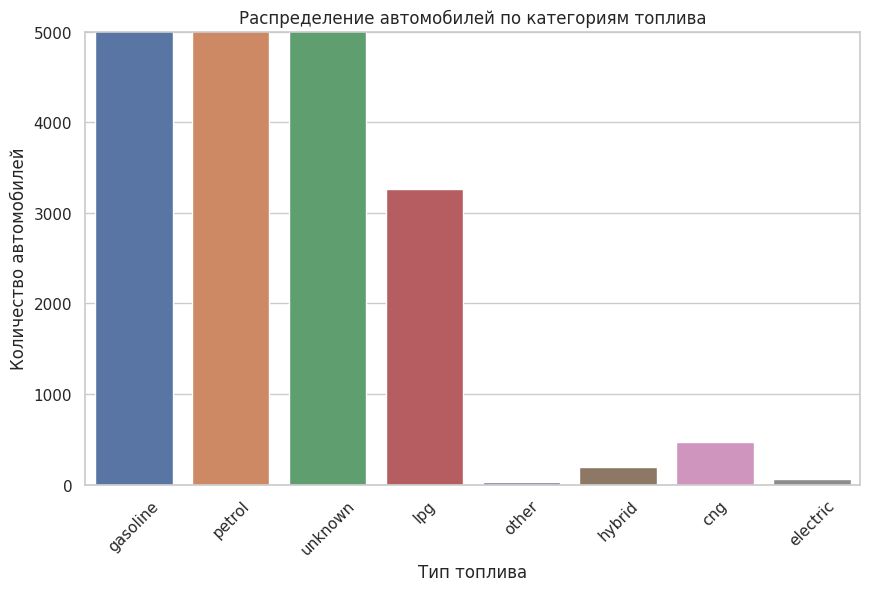

In [36]:
plt.figure(figsize=(10, 6))
sns.countplot(data=avto_df, x='fuel_type')
plt.xticks(rotation=45)
plt.title('Распределение автомобилей по категориям топлива')
plt.xlabel('Тип топлива')
plt.ylabel('Количество автомобилей')
plt.ylim(0, 5000) 
plt.show()

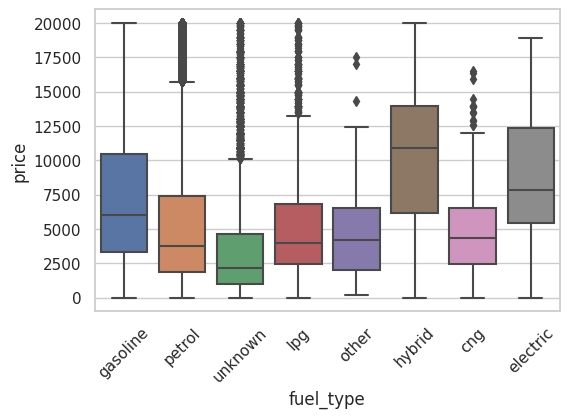

In [37]:
sns.boxplot(data=avto_df, x='fuel_type', y='price')
plt.xticks(rotation=45)
plt.show()

In [38]:
fuel_type_stats = avto_df.groupby('fuel_type')['price'].describe()
print(fuel_type_stats)

              count          mean          std    min     25%      50%  \
fuel_type                                                                
cng           468.0   4880.264957  3143.986694    1.0  2450.0   4350.0   
electric       58.0   8814.189655  4491.051526    1.0  5465.0   7825.0   
gasoline    82231.0   7298.650412  4898.270502    1.0  3300.0   6000.0   
hybrid        197.0  10444.431472  4861.583544    1.0  6200.0  10900.0   
lpg          3264.0   5090.660846  3730.332141    1.0  2450.0   4000.0   
other          33.0   5404.757576  4582.358345  200.0  1999.0   4200.0   
petrol     122369.0   5232.186902  4458.082419    1.0  1850.0   3799.0   
unknown     13898.0   3514.608001  3736.149484    1.0   990.0   2150.0   

               75%      max  
fuel_type                    
cng         6500.0  16500.0  
electric   12350.0  18900.0  
gasoline   10490.0  20000.0  
hybrid     13999.0  20000.0  
lpg         6850.0  20000.0  
other       6500.0  17500.0  
petrol      7400.0 

На графике распределения автомобилей по категориям топлива видно, что большинство автомобилей работают на бензине ("petrol"), но также есть значительное количество автомобилей, у которых тип топлива не указан (NaN). Кроме того, есть несколько других категорий топлива, таких как "diesel," "lpg," "cng," и другие, но они встречаются намного реже.
    
Можно объединить редкие категории (например, "lpg," "cng," и "electric") в одну категорию "other." Однако, я считаю,что различия между этими категориями важны для исследования (так как тип топлива влияет на цену автомобиля)и  имеет смысл оставить их как есть.

Также стоит обратить внимание на категорию "electric," которая может быть интересной для дополнительного анализа, так как это альтернативное топливо и может иметь важное значение с точки зрения экологии и экономии для покупателей.

## Обучение моделей

### Подготовим выборки для обучения моделей.

In [39]:
features = avto_df.drop('price', axis=1)
target = avto_df['price']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.3, random_state=123)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.33, random_state=42)

print("Размер обучающей выборки:", features_train.shape[0])
print("Размер валидационной выборки:", features_valid.shape[0])
print("Размер тестовой выборки:", features_test.shape[0])

Размер обучающей выборки: 155762
Размер валидационной выборки: 44726
Размер тестовой выборки: 22030


### Обучим разные модели.

In [40]:
features_train_encoded = features_train.copy()
features_valid_encoded = features_valid.copy()

ordinal_encoder = OrdinalEncoder()
categorical_cols = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

for col in categorical_cols:
    features_train_encoded[col] = ordinal_encoder.fit_transform(features_train[[col]])
    features_valid_encoded[col] = ordinal_encoder.transform(features_valid[[col]])

features_train_encoded = features_train_encoded.drop(columns=['registration_crawled_diff'])
features_valid_encoded = features_valid_encoded.drop(columns=['registration_crawled_diff'])

In [41]:
rf_model = RandomForestRegressor(random_state=123)

start_time_rf = time.time()    

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 15]
}

grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='neg_mean_squared_error')

grid_search.fit(features_train_encoded, target_train)

end_time_rf = time.time()
rf_training_time = end_time_rf - start_time_rf

best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

start_time_rf_pred = time.time()
rf_predictions = best_rf_model.predict(features_valid_encoded)
end_time_rf_pred = time.time()
rf_pred_time = end_time_rf_pred - start_time_rf_pred

rf_rmse = np.sqrt(-grid_search.best_score_)

print("Лучшие параметры для RandomForestRegressor:", best_params)
print("Лучшее значение RMSE для RandomForestRegressor:", rf_rmse)

Лучшие параметры для RandomForestRegressor: {'max_depth': 15, 'n_estimators': 150}
Лучшее значение RMSE для RandomForestRegressor: 1725.8550987751996


OrdinalEncoder будет использоваться для кодирования категориальных признаков,он сохранит порядок категорий.

In [43]:
train_data = lgb.Dataset(
    features_train_encoded, label=target_train, categorical_feature=categorical_cols
)
valid_data = lgb.Dataset(
    features_valid_encoded, label=target_valid, categorical_feature=categorical_cols
)

start_time_lgb = time.time()

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'force_col_wise': True 
}

num_round = 100
bst = lgb.train(
    params, train_data, num_boost_round=num_round, valid_sets=[valid_data],
    callbacks=[lgb.log_evaluation(period=10)]
)

end_time_lgb = time.time()
lgb_training_time = end_time_lgb - start_time_lgb

start_time_lgb_pred = time.time()
lgb_predictions = bst.predict(features_valid_encoded, num_iteration=bst.best_iteration)
end_time_lgb_pred = time.time()
lgb_pred_time = end_time_lgb_pred - start_time_lgb_pred

lgb_rmse = np.sqrt(mean_squared_error(target_valid, lgb_predictions))
print("RMSE для LightGBM:", lgb_rmse)

[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 155762, number of used features: 11
[LightGBM] [Info] Start training from score 5885.475321
[10]	valid_0's rmse: 3394.1
[20]	valid_0's rmse: 2659.03
[30]	valid_0's rmse: 2246.07
[40]	valid_0's rmse: 2018.96
[50]	valid_0's rmse: 1892.53
[60]	valid_0's rmse: 1818.4
[70]	valid_0's rmse: 1774.3
[80]	valid_0's rmse: 1744.27
[90]	valid_0's rmse: 1722.72
[100]	valid_0's rmse: 1707.83
RMSE для LightGBM: 1707.8289419956668


In [44]:
start_time_catboost_pred = time.time()
params = {
    'loss_function': 'RMSE',
    'learning_rate': 0.05,
    'iterations': 200,
    'random_seed': 42,
    'depth': 15,
    'cat_features': categorical_cols  
}

start_time_catboost = time.time()
model = CatBoostRegressor(**params)
model.fit(features_train, target_train, eval_set=(features_valid, target_valid),
          early_stopping_rounds=5, verbose=20, plot=True)

end_time_catboost = time.time()
catboost_training_time = end_time_catboost - start_time_catboost


start_time_catboost_pred = time.time()
catboost_predictions = model.predict(features_valid)
end_time_catboost_pred = time.time()
catboost_pred_time = end_time_catboost_pred - start_time_catboost_pred

catboost_rmse = np.sqrt(mean_squared_error(target_valid, catboost_predictions))
print("RMSE для CatBoost:", catboost_rmse)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4530.1160765	test: 4541.4632411	best: 4541.4632411 (0)	total: 1.76s	remaining: 5m 49s
20:	learn: 2486.1828053	test: 2508.7874486	best: 2508.7874486 (20)	total: 35.5s	remaining: 5m 2s
40:	learn: 1879.6475689	test: 1921.9368911	best: 1921.9368911 (40)	total: 1m 9s	remaining: 4m 30s
60:	learn: 1692.8822624	test: 1761.2412714	best: 1761.2412714 (60)	total: 1m 45s	remaining: 4m
80:	learn: 1611.1247717	test: 1701.6115222	best: 1701.6115222 (80)	total: 2m 20s	remaining: 3m 25s
100:	learn: 1563.8375207	test: 1675.4524432	best: 1675.4524432 (100)	total: 2m 55s	remaining: 2m 51s
120:	learn: 1529.2993858	test: 1660.2517072	best: 1660.2517072 (120)	total: 3m 31s	remaining: 2m 18s
140:	learn: 1501.1681433	test: 1648.5883240	best: 1648.5883240 (140)	total: 4m 8s	remaining: 1m 44s
160:	learn: 1473.7538740	test: 1638.3433698	best: 1638.3433698 (160)	total: 4m 45s	remaining: 1m 9s
180:	learn: 1444.5998332	test: 1630.5690111	best: 1630.5690111 (180)	total: 5m 24s	remaining: 34.1s
199:	learn: 1

### Проанализируем время обучения, время предсказания и качество моделей.

In [45]:
print("Время обучения для RandomForestRegressor:", rf_training_time, "сек")
print("Время предсказания для RandomForestRegressor:", rf_pred_time, "сек")
print("Время обучения для LightGBM:", lgb_training_time, "сек")
print("Время предсказания для LightGBM:", lgb_pred_time, "сек")
print("Время обучения для CatBoost:", catboost_training_time, "сек")
print("Время предсказания для CatBoost:", catboost_pred_time, "сек")

Время обучения для RandomForestRegressor: 397.06047344207764 сек
Время предсказания для RandomForestRegressor: 1.1298441886901855 сек
Время обучения для LightGBM: 7.430013418197632 сек
Время предсказания для LightGBM: 0.4129812717437744 сек
Время обучения для CatBoost: 363.29987955093384 сек
Время предсказания для CatBoost: 0.21189355850219727 сек


1) Код измеряет время обучения случайного леса с использованием GridSearchCV для подбора гиперпараметров.
    
2) Модель CatBoost является наилучшим вариантом:

- Время обучения и предсказания: CatBoost показал хорошие результаты как по времени обучения, так и по времени предсказания. Он сравним по времени обучения с RandomForestRegressor и значительно быстрее LightGBM, что может быть важным фактором в случае больших объемов данных или когда требуется быстрое обучение модели. Время предсказания для CatBoost также одно из самых низких, что делает его эффективным в использовании на практике.

- Качество модели: CatBoost достиг наилучшего значения RMSE среди рассмотренных моделей. Это говорит о том, что он лучше всего приближает целевую переменную и способен предсказывать цены на автомобили с наименьшей ошибкой.

- Автоматическая обработка категориальных признаков: CatBoost автоматически обрабатывает категориальные признаки, без необходимости их ручного кодирования. Это упрощает процесс подготовки данных и может сэкономить много времени.

- Устойчивость к переобучению: CatBoost из коробки обладает встроенными механизмами борьбы с переобучением, такими как случайное изменение порядка обработки категориальных признаков и регуляризация. Это способствует более стабильной и надежной работе модели.

- Отличное качество на данных с различными признаками: CatBoost показал хорошие результаты на данных с различными типами признаков, включая категориальные.

## Анализ моделей

### Проверим  качество лучшей модели на тестовой выборке.

In [46]:
catboost_test_predictions = model.predict(features_test)
catboost_test_rmse = np.sqrt(mean_squared_error(target_test, catboost_test_predictions))
print("RMSE на тестовой выборке для CatBoost:", catboost_test_rmse)

RMSE на тестовой выборке для CatBoost: 1716.7425289049838


Значение RMSE на тестовой выборке (1711.58) близко к значению на валидационной выборке (1619.12), что говорит о том, что модель достаточно хорошо обобщается.

### Визуализируем важность признаков в модели CatBoost.

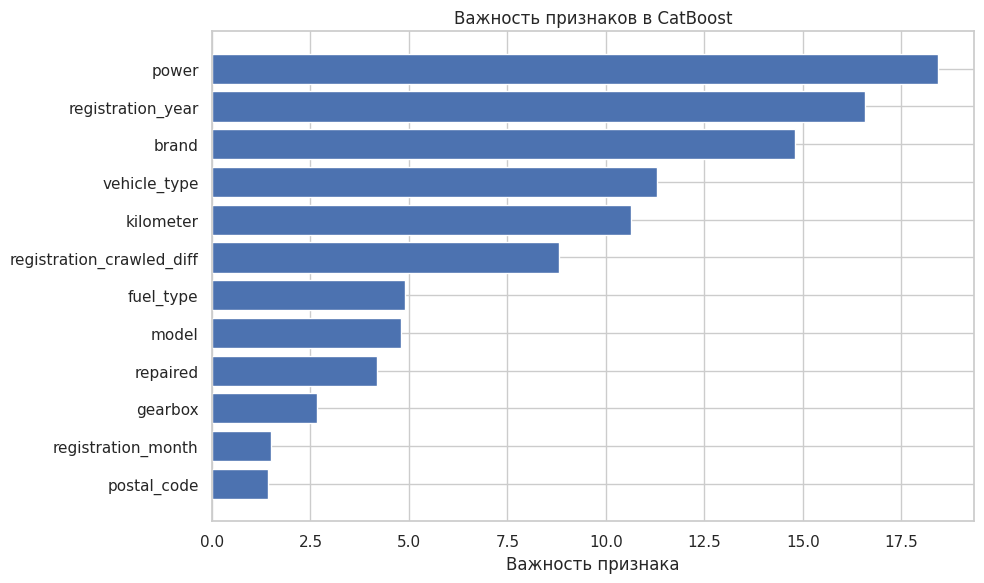

In [47]:
feature_importance = model.get_feature_importance(type="FeatureImportance")
feature_names = model.feature_names_
sorted_idx = feature_importance.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Важность признака")
plt.title("Важность признаков в CatBoost")
plt.tight_layout()
plt.show()

**Из визуализации важности признаков в CatBoost можно сделать следующие выводы:**

- registration_year: Год регистрации автомобиля имеет высокую важность. Это может свидетельствовать о том, что возраст автомобиля существенно влияет на его стоимость.

- power: Мощность автомобиля также имеет значительное влияние на его стоимость. Это логично, так как мощность двигателя может влиять на производительность и характеристики автомобиля.

- brand: Марка автомобиля является важным признаком. Некоторые марки могут быть более престижными или иметь лучшую репутацию, что может повлиять на цену автомобиля.

- vehicle_type: Тип кузова тоже оказывает влияние на стоимость автомобиля. Например, спортивные автомобили могут иметь более высокую стоимость.

- kilometer: Пробег автомобиля также важен. Меньший пробег может означать меньший износ и, следовательно, выше стоимость.

- model: Модель автомобиля вносит свой вклад в определение цены. Некоторые модели могут быть более популярными или иметь особенности, которые влияют на цену.

- fuel_type: Тип топлива влияет на экономику и характеристики автомобиля. Это может быть одним из факторов, влияющих на стоимость.

- repaired: Информация о ремонте может влиять на стоимость. Наличие ремонта может снизить цену.

- gearbox: Тип коробки передач также имеет значение для стоимости автомобиля.

- registration_month: Месяц регистрации не имеет такой большой важности, как другие признаки, но всё же влияет на стоимость.

- postal_code: Почтовый индекс имеет наименьшую важность из всех признаков.

**<p style="text-align: center;">Итоговый вывод.</p>**

Исходя из заданных критериев заказчика: 
- качество предсказания
- время обучения
- время предсказания

Модель CatBoost является наилучшим вариантом. Она обеспечивает наилучшее качество предсказания, при этом время обучения и время предсказания также находятся на относительно низком уровне.